# Bottom Age Anomaly


In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.colors as col
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cosima_cookbook as cc
import cmocean.cm as cmocean
import cmocean.cm as cm
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: /proxy/8787/status,
Status: running,Using processes: True
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 188.57 GiB
Comm: tcp://127.0.0.1:38837,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.57 GiB
Comm: tcp://127.0.0.1:33665,Total threads: 6
Dashboard: /proxy/43507/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:34105,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

# plot anomalies for last 5 years of simulation:
start_time='2160-01-01'
end_time='2164-12-31'

lat_slice  = slice(-80,-59)

In [10]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=13

## Bottom age averaged over years 11-15

In [6]:
age_con = cc.querying.getvar(control,'age_global' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
age_con = age_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

age_up = cc.querying.getvar(easterlies_up,'age_global' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
age_up = age_up.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

age_down = cc.querying.getvar(easterlies_down,'age_global' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
age_down = age_down.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time')                             

# select out bottom values:
depth_array = age_con * 0 + age_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_age_con = age_con.where(depth_array.st_ocean >= max_depth)
bottom_age_con = bottom_age_con.sum(dim = 'st_ocean')
bottom_age_con = bottom_age_con.load()

bottom_age_up = age_up.where(depth_array.st_ocean >= max_depth)
bottom_age_up = bottom_age_up.sum(dim = 'st_ocean')
bottom_age_up = bottom_age_up.load()

bottom_age_down = age_down.where(depth_array.st_ocean >= max_depth)
bottom_age_down = bottom_age_down.sum(dim = 'st_ocean')
bottom_age_down = bottom_age_down.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysi

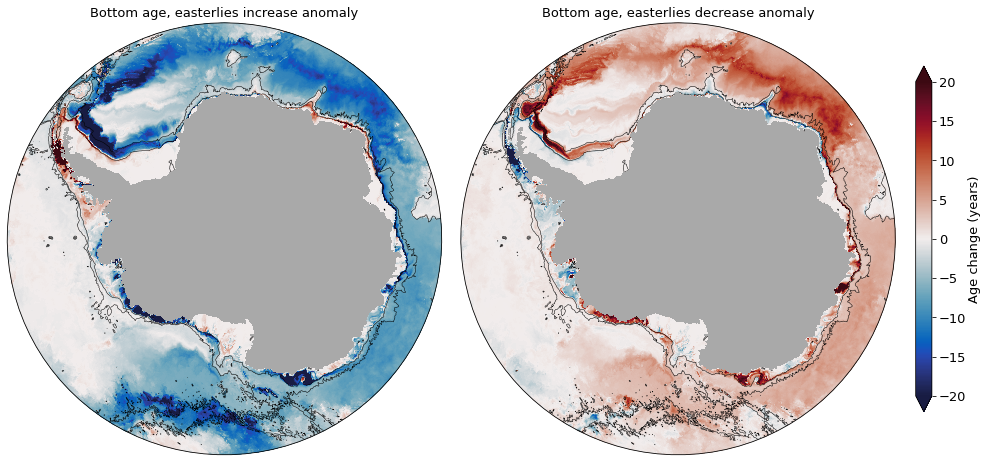

In [13]:
scale_max = 20

fig  = plt.figure(1, figsize = (15,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# up:
# setup stereo projection:
ax = fig.add_axes([0.0, 0.5, 0.5, 0.5],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_age_con.xt_ocean, bottom_age_con.yt_ocean, bottom_age_up-bottom_age_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Bottom age, easterlies increase anomaly',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# down:
# setup stereo projection:
ax = fig.add_axes([0.42, 0.5, 0.5, 0.5],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_age_con.xt_ocean, bottom_age_con.yt_ocean, bottom_age_down-bottom_age_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Bottom age, easterlies decrease anomaly',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.89, 0.55, 0.015, 0.4])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Age change (years)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)